# copy the data from Input to Working
/kaggle/input (Where your data is now): This is Network Storage. It is read-only and acts like an external hard drive connected over a USB cable. It is slower because the GPU has to "fetch" images constantly.

/kaggle/working (The Fast Lane): This is the Local RAM/Disk of the machine. This is where you want your data for maximum speed.

In [6]:
import os
import shutil

# 1. Configuration
# This is the path you shared
SOURCE_PATH = "/kaggle/input/hg14-dataset-splited/data" 
# This is the fast local target
DEST_PATH = "/kaggle/working/data" 
# shutil.rmtree(DEST_PATH)
# 2. Copy Logic
if not os.path.exists(DEST_PATH):
    print(f"Copying data from {SOURCE_PATH} to fast local storage...")
    try:
        shutil.copytree(SOURCE_PATH, DEST_PATH)
        print("Copy complete! Data is now on fast local disk.")
    except Exception as e:
        print(f"Error copying: {e}")
else:
    print("Data already exists in fast storage. Skipping copy.")

Copying data from /kaggle/input/hg14-dataset-splited/data to fast local storage...
Copy complete! Data is now on fast local disk.


# Load the dataset from directories

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = "/kaggle/working/data" # Point to the FAST copy we just made

print(f"Loading data from: {DATA_DIR}")

# 1. Training Set (80% of the 'train' folder)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    validation_split=0.2,    # 20% for validation
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# 2. Validation Set (20% of the 'train' folder)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DATA_DIR}/train",
    validation_split=0.2,
    subset="validation",
    seed=42,                 # Must match train_ds seed!
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# 3. Test Set (100% of the 'test' folder)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"{DATA_DIR}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False            # Never shuffle test data
)

Loading data from: /kaggle/working/data
Found 11200 files belonging to 14 classes.
Using 8960 files for training.


I0000 00:00:1765573214.466980      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 11200 files belonging to 14 classes.
Using 2240 files for validation.
Found 2800 files belonging to 14 classes.


# Visualize sample images

Classes: ['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']


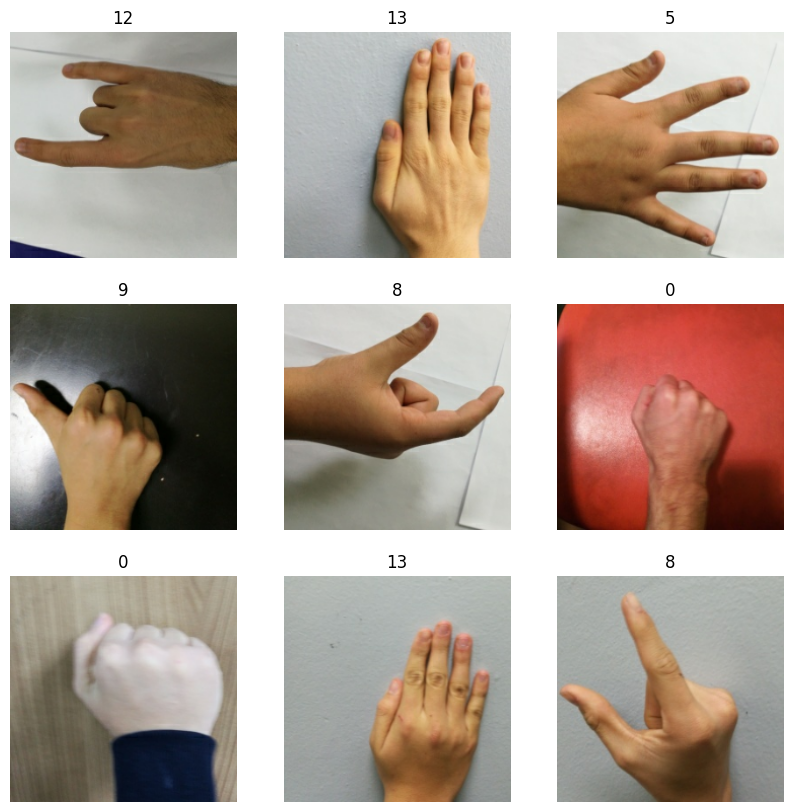

In [8]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
print("Classes:", class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")

# Visualize Class Balance

Extracting labels from dataset...


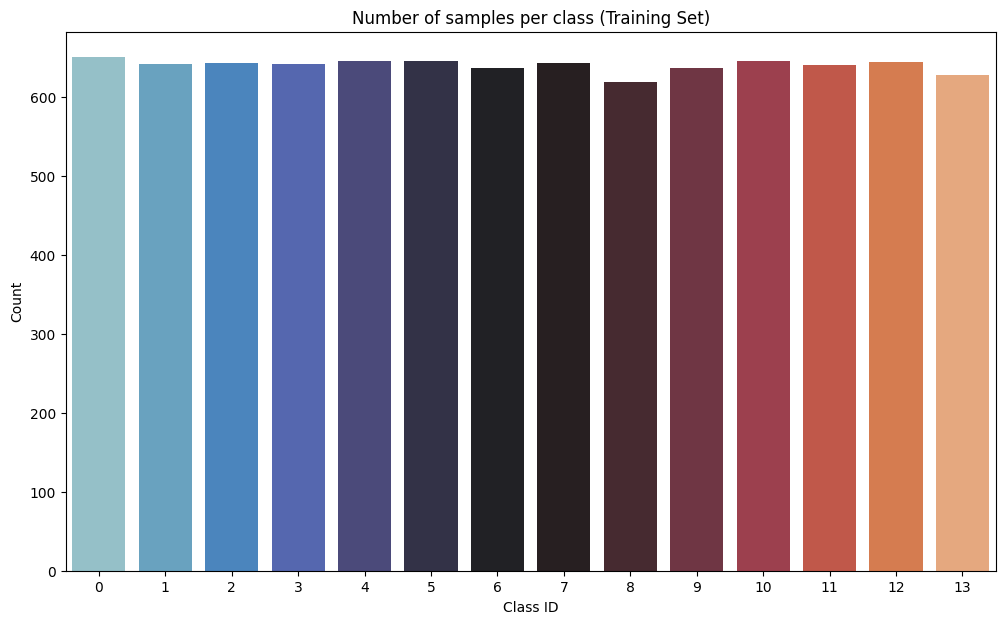

Counts per class: {0: 650, 1: 641, 2: 643, 3: 641, 4: 646, 5: 646, 6: 636, 7: 643, 8: 619, 9: 637, 10: 646, 11: 640, 12: 644, 13: 628}


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# 1. Create a list to hold all labels
y_train_labels = []

# 2. Iterate through the dataset to extract labels
# unbatch() breaks the batches of 32 down into single images so we can count them
print("Extracting labels from dataset...")
for images, labels in train_ds.unbatch():
    # 'labels' is one-hot encoded (e.g., [0, 0, 1, 0...]) because of label_mode='categorical'
    # argmax converts it back to a single integer (e.g., 2)
    y_train_labels.append(tf.argmax(labels).numpy())

# Convert to a numpy array for easy counting
y_train_labels = np.array(y_train_labels)

# 3. Visualize (Similar to your tutorial)
plt.figure(figsize=(12, 7))
sns.countplot(x=y_train_labels, palette="icefire")
plt.title("Number of samples per class (Training Set)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

# 4. Print exact numbers
unique, counts = np.unique(y_train_labels, return_counts=True)
print("Counts per class:", dict(zip(unique, counts)))

# Set the arcarchitecture 

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50

# --- 1. Load the ResNet50 Base (Standard Keras Way) ---
# We use the built-in Keras version. It is more stable than Hub for ResNet.
base_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base
base_resnet.trainable = False

# --- 2. Build the Model (Linear Functional API) ---

# A. Define Input
inputs = tf.keras.Input(shape=(224, 224, 3))

# B. Preprocessing (CRITICAL CHANGE)
# ResNet expects specific preprocessing (Zero-centering), NOT just 0-1 scaling.
# We use a Lambda layer to apply the official ResNet preprocessing function.
# Note: This function expects [0, 255] inputs (which is what the dataset is).
x = layers.Lambda(tf.keras.applications.resnet50.preprocess_input, name='resnet_preprocess')(inputs)

# C. Pass through ResNet Base
# We pass the preprocessed data into the frozen base model
x = base_resnet(x, training=False)

# D. Pooling (Flattening)
# The base outputs a 7x7 box. We need to squash it into a vector.
x = layers.GlobalAveragePooling2D()(x)

# E. Classification Head
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation='softmax')(x)

# F. Stitch it into a Model
model = models.Model(inputs=inputs, outputs=outputs, name="ResNet50_Transfer")

# --- 3. Compile & Train ---
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet_preprocess (Lambda)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,854 (91.99 MB)

 Trainable params: 528,142 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compiling

In [13]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), # Low learning rate for deep networks
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# CRITICAL OPTIMIZATION

In [14]:
# This keeps the GPU running at 100% without waiting for data loading
AUTOTUNE = tf.data.AUTOTUNE
prefetched_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
prefetched_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
prefetched_test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training 

In [15]:
epochs = 15 # Start with 15, you can increase later
history = model.fit(
    prefetched_train_ds,
    validation_data=prefetched_val_ds,
    epochs=epochs
)

Epoch 1/15


I0000 00:00:1765573539.835690     183 service.cc:148] XLA service 0x7fa7940023f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765573539.836502     183 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765573541.395935     183 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/280 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.0503 - loss: 3.7806   

I0000 00:00:1765573545.521806     183 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step - accuracy: 0.1817 - loss: 2.6438 - val_accuracy: 0.6045 - val_loss: 1.4781
Epoch 2/15
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.5170 - loss: 1.4947 - val_accuracy: 0.7219 - val_loss: 1.0196
Epoch 3/15
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.6319 - loss: 1.1095 - val_accuracy: 0.8040 - val_loss: 0.7814
Epoch 4/15
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.7157 - loss: 0.8792 - val_accuracy: 0.8415 - val_loss: 0.6347
Epoch 5/15
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.7689 - loss: 0.7201 - val_accuracy: 0.8665 - val_loss: 0.5338
Epoch 6/15
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8074 - loss: 0.6125 - val_accuracy: 0.8781 - val_loss: 0.4761
Epoch 7/15
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8283 - loss: 0.5445 - val_accuracy: 0.8991 - val_loss: 0.4124
Epoch 8/15
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8518 - loss: 0.4874 - val_accurac

# Save & Download

In [16]:
from IPython.display import FileLink

# Save
model.save('resnet_transfer-learning_HG14.keras')

# Create Download Link
print("Training done! Click below to download your model:")
display(FileLink(r'resnet_transfer-learning_HG14.keras'))

Training done! Click below to download your model:


/kaggle/working/resnet_transfer-learning_HG14.keras

# Visualize the Training "Story

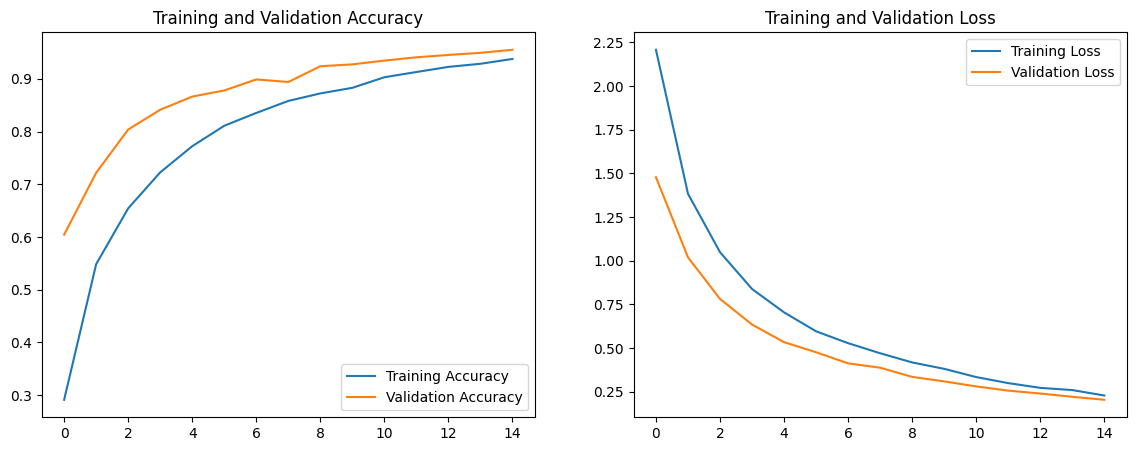

In [17]:
import matplotlib.pyplot as plt

# Extract results from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test Set Evaluation

Generating predictions on Test Set...
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       200
           1       0.78      0.86      0.82       200
          10       0.72      0.67      0.69       200
          11       0.88      0.81      0.85       200
          12       0.72      0.64      0.68       200
          13       0.69      0.93      0.79       200
           2       0.76      0.57      0.66       200
           3       0.67      0.60      0.64       200
           4       0.77      0.86      0.82       200
           5       0.97      0.90      0.93       200
           6       0.50      0.62      0.55       200
           7       0.93      0.99      0.96       200
           8       0.96      0.91      0.93       200
           9       0.73      0.68      0.70       200

    accuracy                           0.78      2800
   macro avg       0.79

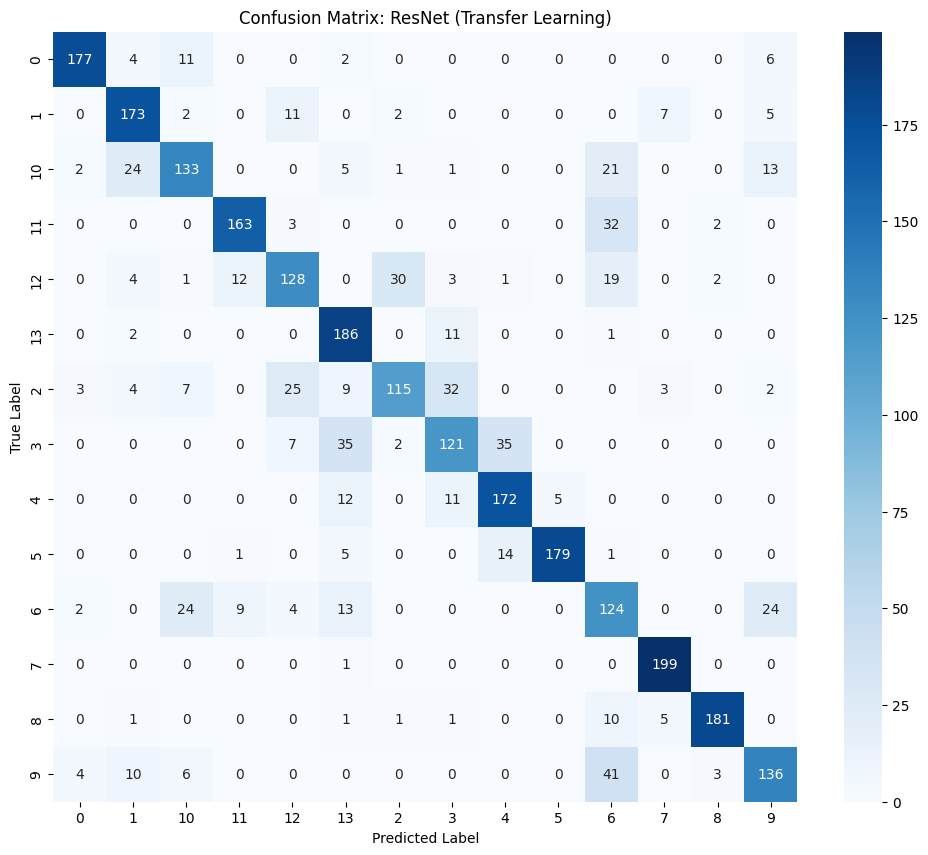

In [18]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get Predictions (This might take a minute)
print("Generating predictions on Test Set...")
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# 2. Get True Labels
# We iterate through the test_ds to get the true labels in the same order
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# 3. Get Class Names (e.g., Gesture_0, Gesture_1...)
class_names = train_ds.class_names

# 4. Generate Classification Report (Precision, Recall, F1-Score)
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Visualize Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: ResNet (Transfer Learning)')
plt.show()

# Single Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


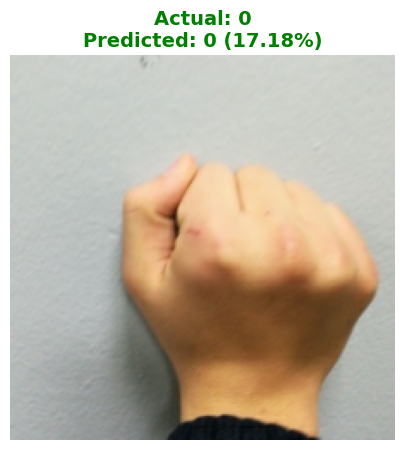

Model believes this is 0 with 17.18% confidence.


In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# 1. Get Class Names (to convert numbers like '0' back to 'Gesture_0')
class_names = train_ds.class_names

# 2. Grab a single image from the Test Set
# .unbatch() separates the batches of 32 into individual images
# .take(1) grabs just the first one it finds
for image, label in test_ds.unbatch().take(1):
    
    # 3. Prepare the image for the model
    # The model expects a batch of images (e.g., [1, 128, 128, 3]), not just one.
    # expand_dims adds that fake "batch of 1" dimension.
    img_array = tf.expand_dims(image, 0) 
    
    # 4. Ask Model to Predict
    predictions = model.predict(img_array)
    
    # 5. Process Result
    # Softmax converts raw numbers into percentages (probabilities)
    score = tf.nn.softmax(predictions[0]) 
    
    predicted_class = class_names[np.argmax(score)]
    true_class = class_names[np.argmax(label)]
    confidence = 100 * np.max(score)
    
    # 6. Display Visual Proof
    plt.figure(figsize=(5, 5))
    plt.imshow(image.numpy().astype("uint8"))
    
    # Set title color: Green if correct, Red if wrong
    result_color = "green" if predicted_class == true_class else "red"
    
    plt.title(f"Actual: {true_class}\nPredicted: {predicted_class} ({confidence:.2f}%)", 
              color=result_color, fontsize=14, fontweight='bold')
    plt.axis("off")
    plt.show()

    print(f"Model believes this is {predicted_class} with {confidence:.2f}% confidence.")

# ROC & AUC Code

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step


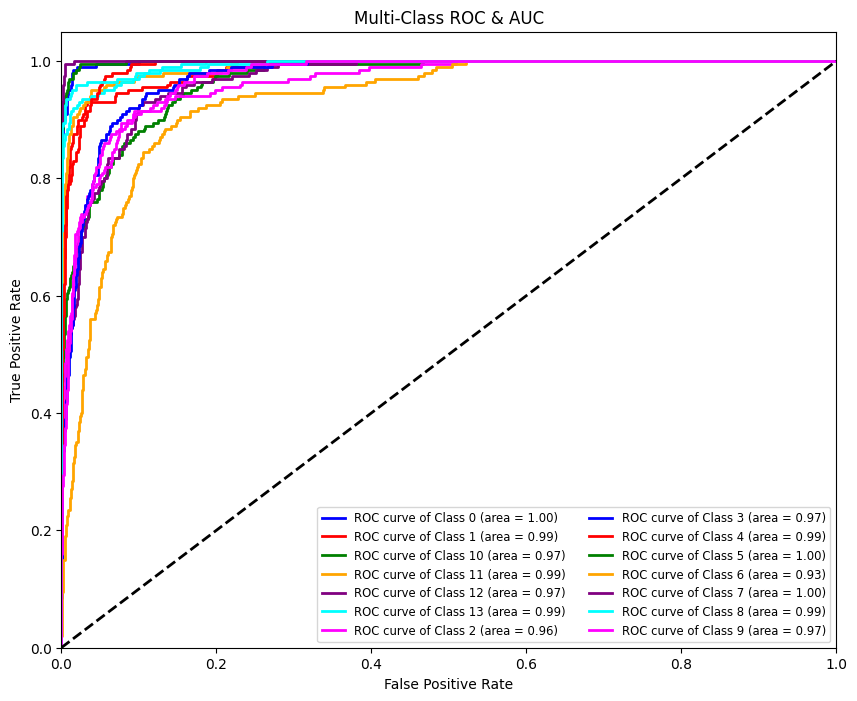

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# 1. Get the One-Hot Encoded True Labels & Prediction Probabilities
# We need the raw probabilities (e.g., 0.75), not just the final class (e.g., "Class 0")
y_true_onehot = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)

# 2. Setup for Multi-Class ROC
n_classes = 14
fpr = dict()
tpr = dict()
roc_auc = dict()

# 3. Calculate ROC for each class
for i in range(n_classes):
    # Compares "Is it Class i?" vs "Is it ANY other class?"
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plotting (We'll plot the first 5 classes to keep it readable, or all if you prefer)
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of Class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Dashed diagonal line (Random Guessing)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC & AUC')
plt.legend(loc="lower right", fontsize='small', ncol=2)
plt.show()